# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import plotly.express as px 

In [2]:
# фиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
cols=df.columns # получаем список признаков
for col in cols: # создаем цикл вывода всех признаков с подсчетом уникалыных значений
    print(col)
    print(df[col].value_counts())


age
31    496
32    477
34    466
33    464
35    461
     ... 
92      2
93      2
88      2
95      1
89      1
Name: age, Length: 76, dtype: int64
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
marital
married     6351
single      3518
divorced    1293
Name: marital, dtype: int64
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64
default
no     10994
yes      168
Name: default, dtype: int64
balance
0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64
housing
no     5881
yes    

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def correct_balance(x):
    """Функий корректировки занчений Balance
    Args:
        x (object): значение ячейки балансе в неробрабоьанном виде

    Returns:
        x: баланс клеинта в с типом Float
    """
    x=str(x)
    x=x.replace(' ','')
    x=x.replace(',00','')
    x=x.replace('$','')
    
    return float(x)
df['balance'] = df['balance'].apply(correct_balance) #обрабатываем значение balance

In [7]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [9]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [11]:
round(df.groupby(['job','education'])['balance'].agg('mean')[df['job'].mode()[0],df['education'].mode()[0]],3)

1598.883

### Задание 6

Нижня граница: -2241 Верхняя граница: 4063


10105

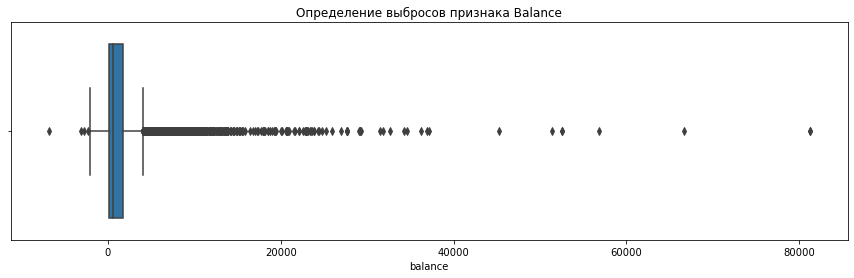

In [12]:
# удалите все выбросы для признака balance
# визуализируем распределение и выбросы по признаку Balance
fig, ax = plt.subplots(figsize=(15, 4))
boxplot = sns.boxplot(data=df, x='balance', ax=ax);
boxplot.set_title('Определение выбросов признака Balance')

def outliers_iqr(data, feature):
    """Функция определения выбросов (Тьюки)

    Args:
        data (DataFrame): набор данных для очистки
        feature (str): признак по которому будет проводистя очистка

    Returns:
        Data frame : отфильтрованный df, очищенный df
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    print('Нижня граница:',round(lower_bound), 'Верхняя граница:', round(upper_bound))
    return outliers, cleaned
df_out, df_cleaned = outliers_iqr(df, 'balance')

df_cleaned.shape[0]


## Часть 2:  Разведывательный анализ

### Задание 1

                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  


Text(0.5, 1.0, 'Соотношение клинетов оформивших депозиты')

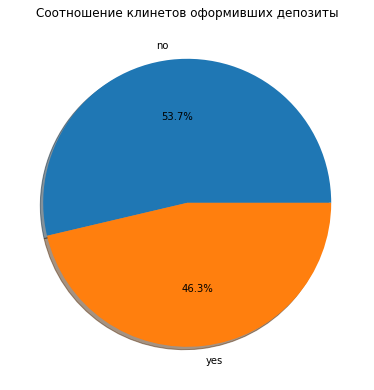

In [13]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
dfc = df_cleaned.copy() #создаем копию данных
print(dfc.describe())
print(dfc['deposit'].value_counts())

fig = plt.figure(figsize=(5, 5)) # Построим визуализацию разделения лтиентов оформивших депозит
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    dfc['deposit'].value_counts(),
    labels=dfc['deposit'].value_counts().index,
    autopct='%.1f%%',
    shadow=True)
axes.set_title('Соотношение клинетов оформивших депозиты')

#Большая часть клиентов не оформила депозиты

### Задание 2

                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  


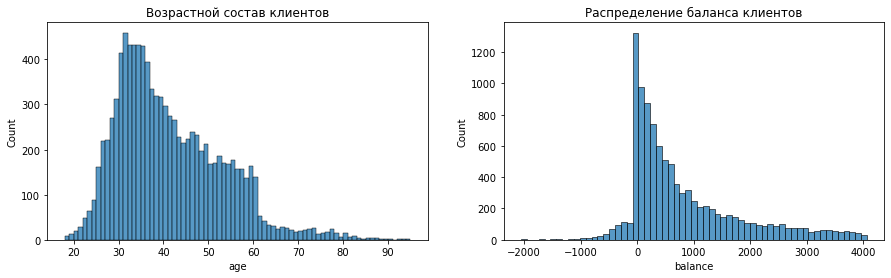

In [14]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(dfc.describe())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4)) # Иллюстрация распределения возрастного состава клиентов и баланса на счетах
sns.histplot(
    data=dfc,
    x='age',
    bins=((dfc['age'].max())-(dfc['age'].min())),
    ax=axes[0]
)
axes[0].set_title('Возрастной состав клиентов')
sns.histplot(
    data=dfc,
    x='balance',
    ax=axes[1]
)
axes[1].set_title('Распределение баланса клиентов')
print(dfc['age'].max())
# основное количество клиентов в возрасте от 25 до 60 лет,
# больша часть клиентов имеет небольшой бананс на счете до 200 дол.
# В среднем с клиентов связываются раз в 2 месяца, с некотовы клиентами не общались более 2 лет.

### Задание 3

               job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424  


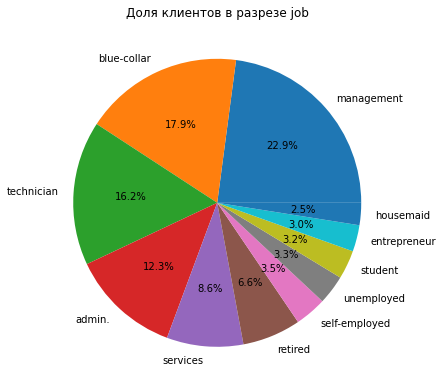

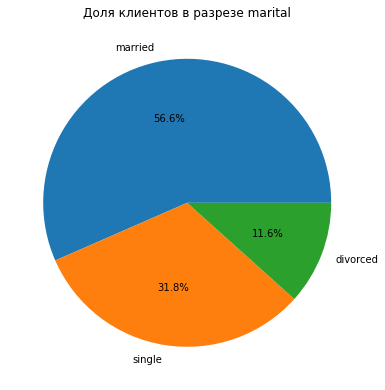

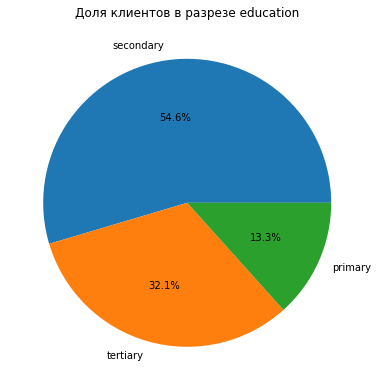

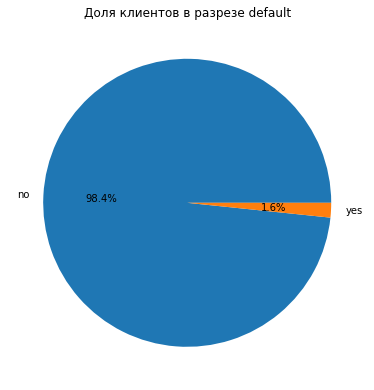

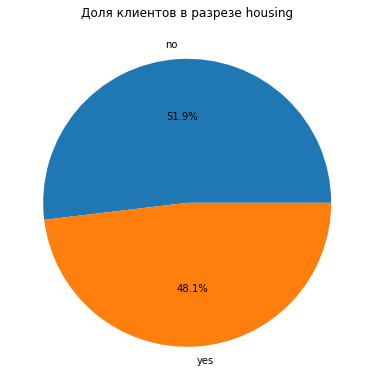

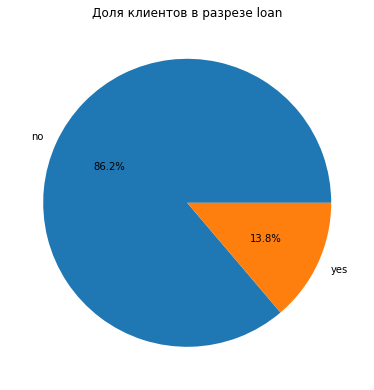

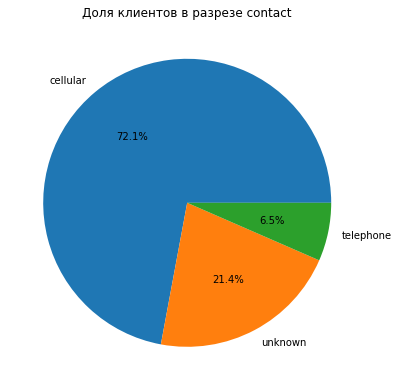

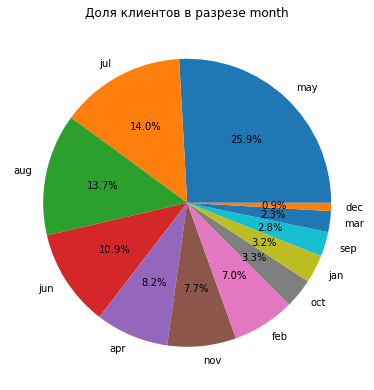

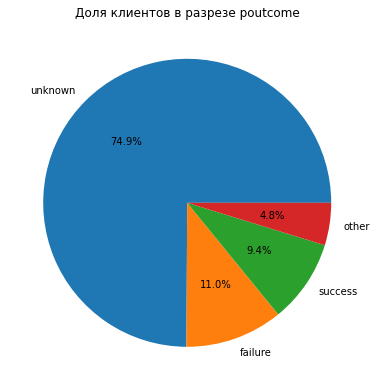

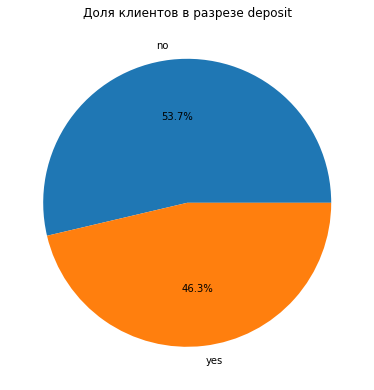

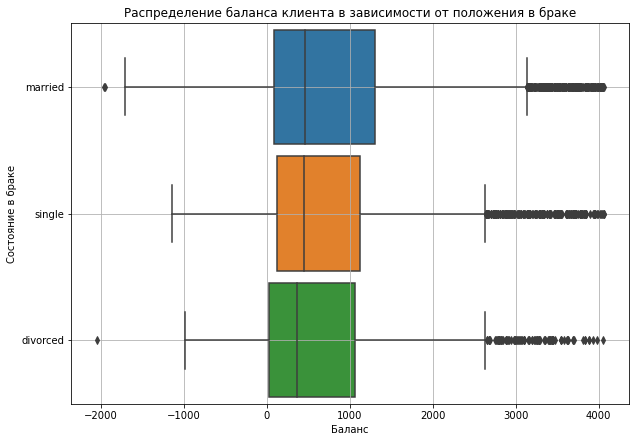

In [15]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
print(dfc.describe(include='object'))
types = dfc.dtypes # создадим список всех типов признаков
cat_features = list(types[(types == 'object')].index) # отберем категориальные признаков
num_features = list(types[(types != 'object')].index) # отберем числовые признаков

n = len(cat_features) #количество категориальных признаков
#Создаем цикл для иллюстрации всех признаков из списка категориальных
for feature in cat_features: # feature - название признака в таблице
    fig = plt.figure(figsize=(5, 5))
    axes = fig.add_axes([0, 0, 1, 1])
    axes.pie(
    dfc[feature].value_counts(),
    labels=dfc[feature].value_counts().index,
    autopct='%.1f%%')
    axes.set_title('Доля клиентов в разрезе {}'.format(feature))
# четверть наблюдений работают менеджерами
# половина респондентов женаты
# половина респондентов имеют среднее образование
# половина респондентов не имеют кредитов на жилье
# Маркетинговая компани проводилась в основном с Мая по Август

#постройте визуализации, иллюстрирующие результаты

fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=dfc,
    y='marital',
    x='balance',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение баланса клиента в зависимости от положения в браке');
boxplot.set_xlabel('Баланс');
boxplot.set_ylabel('Состояние в браке');
boxplot.grid()

### Задание 4

In [16]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
dfc.groupby(['poutcome','deposit'])[['deposit']].count()


deposit
poutcome deposit         
failure  no           562
         yes          547
other    no           216
         yes          265
success  no            84
         yes          861
unknown  no          4562
         yes         3008

### Задание 5

In [17]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
def percent_func (x,y,z='Готовность открыть депозит'): #создадим универсальную функцию подсчета процента согласия на откртие депозита в различных признаках
    """Фукция подсчета процентного соотношения категорий к целевому признаку

    Args:
        x (str): наименовнаие признака категорий
        y (str): наименовнаие целевого признака
        z (str): Наименование графика визуализации
    """
   # узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
    cat_list = list(dfc[x].unique()) #создаем список категорий в признаке
    result_dict = {} # формируем словарь для хранения результата
    for cat in cat_list: #цикл расчета % положительных и отрицательных исходов маркетинговой компании
        result_percent = ((dfc[dfc[x]==cat][y].value_counts())/(dfc[dfc[x]==cat][y].count()))*100
        result_dict[cat]=round(result_percent,2)
    # добавим визуализацию
    fig = px.histogram(
    data_frame = dfc,
    x = x,
    color = y,
    height = 700,
    width = 700,
    title = z,
    )
    fig.show()
    return(pd.DataFrame(result_dict)) #возвращает датафрейм на случай большого количества категорий

    
display(percent_func('month','deposit')) #подсчитаем для месяца

,may,jun,jul,aug,oct,nov,dec,jan,feb,mar,apr,sep
no,67.86,54.89,58.96,55.96,18.51,58.46,9.68,60.82,45.56,10.13,38.19,16.55
yes,32.14,45.11,41.04,44.04,81.49,41.54,90.32,39.18,54.44,89.87,61.81,83.45


### Задание 6

In [18]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group (age): #создадим функцию присвоения возрастной группы
    if age < 30:
        return '<30'
    elif 30<=age<40:
        return '30-40'
    elif 40<=age<50:
        return '40-50'
    elif 50<=age<60:
        return '50-60'
    else:
        return '60+'

dfc['age_group']=dfc['age'].apply(age_group)

display(percent_func('age_group','deposit','Готовность открыть депозит в взависимости от возраста'))

#по визуализации в своей группе готовы открыть депозит клиенты 60+
#в процентном отношении внутри группы 76% возврасной группы 60+ готовы открыть депозит.



,50-60,40-50,60+,30-40,<30
no,59.49,60.62,24.04,56.68,40.82
yes,40.51,39.38,75.96,43.32,59.18


### Задание 7

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
display(percent_func('marital','deposit','Готовность открыть депозит в взависимости от семейного положения'))

,married,single,divorced
no,57.8,46.59,53.02
yes,42.2,53.41,46.98


In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
display(percent_func('education','deposit','Готовность открыть депозит в взависимости от образования'))

,secondary,tertiary,primary
no,55.57,47.11,61.68
yes,44.43,52.89,38.32


In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
display(percent_func('job','deposit','Готовность открыть депозит в взависимости от должности'))

,admin.,technician,services,management,retired,blue-collar,unemployed,entrepreneur,housemaid,self-employed,student
no,53.93,54.95,60.25,50.97,34.84,63.92,43.07,63.0,60.71,55.03,24.85
yes,46.07,45.05,39.75,49.03,65.16,36.08,56.93,37.0,39.29,44.97,75.15


### Задание 8

'Образование и семеной положение всех клентов'

education,primary,secondary,tertiary
marital,,,
divorced,187,653,337
married,980,3119,1616
single,182,1745,1286


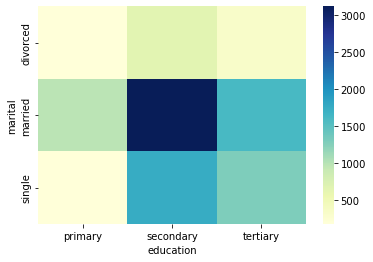

In [22]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
pivot_all=(dfc.pivot_table( 
    values='deposit',  
    index='marital',
    columns='education',
    aggfunc='count',
))
pivot_yes=(dfc[dfc['deposit']=='yes'].pivot_table( 
    values='deposit',  
    index='marital',
    columns='education',
    aggfunc='count',
))
pivot_no=(dfc[dfc['deposit']=='no'].pivot_table( 
    values='deposit',  
    index='marital',
    columns='education',
    aggfunc='count',
))
display('Образование и семеной положение всех клентов',pivot_all)
heatmap = sns.heatmap(data=pivot_all, cmap='YlGnBu')



'Образование и семеной положение оформивших депозит'

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


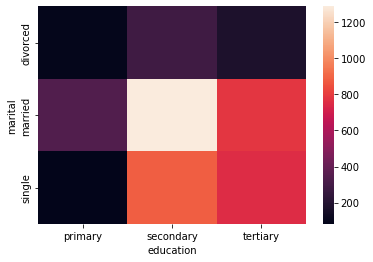

In [23]:
display('Образование и семеной положение оформивших депозит',pivot_yes)
heatmap = sns.heatmap(data=pivot_yes)

'Образование и семеной положение не оформивших депозит'

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


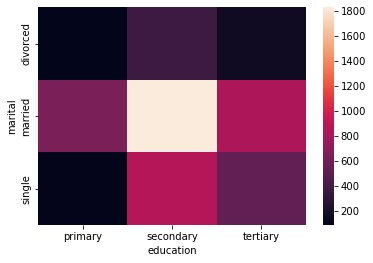

In [24]:
display('Образование и семеной положение не оформивших депозит',pivot_no)
heatmap = sns.heatmap(data=pivot_no)

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования
df_code=dfc.copy() # копируем данные
def le_coder(df,x): #создадим функцию кодировки признаков через LabelEncoder
    """Кодировка признаков черезе LabelEncoder

    Args:
        df (DataFrame): датафрейм в котором необходимо провести кодировку 
        x (str): список признаков необходимых к кодировке

    Returns:
        Исходный DataFrame с закодированными признаками
    """
    for i in x:
        le = LabelEncoder()
        df[i+"_le"] = le.fit_transform(df[i])
    return df[i+"_le"]

types = dfc.dtypes # обновим список типов
cat_features = list(types[(types == 'object')].index) #отберем все категориальные
bin_features = ['default','housing','loan','deposit'] # отделим бинарные
for feature  in bin_features :
    category_features = cat_features.remove(feature)

# Проводим кодировку оставшихся категориальных признаков
# le_coder(df_code,cat_features) # возможность кодировки всех категорианых признаков сразу
le_coder(df_code,['education','age_group'])
df_code = df_code.drop(['education','age_group'], axis=1)# удаляем перекодированные признаки
cat_features.remove('education')
cat_features.remove('age_group')
df_code.describe()


,age,balance,day,duration,campaign,pdays,previous,education_le,age_group_le
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230,1.187036,1.332905
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795,0.647373,1.414007
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000,1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000,1.000000,1.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000,2.000000,2.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000,2.000000,4.000000


### Задание 2

In [26]:
# преобразуйте бинарные переменные в представление из нулей и единиц
for feature in bin_features:
    df_code[feature]= df_code[feature].apply(lambda x: 1 if x == 'yes' else 0)

print(round(df_code['default'].mean()+df_code['housing'].mean()+df_code['loan'].mean(),3))


0.635


### Задание 3

In [27]:
# создайте дамми-переменные
dfc_dumm=df_code.copy() #создаем копию данных
dfc_dumm = pd.get_dummies(dfc_dumm, columns = cat_features)
dfc_dumm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   default            10105 non-null  int64  
 2   balance            10105 non-null  float64
 3   housing            10105 non-null  int64  
 4   loan               10105 non-null  int64  
 5   day                10105 non-null  int64  
 6   duration           10105 non-null  int64  
 7   campaign           10105 non-null  int64  
 8   pdays              10105 non-null  int64  
 9   previous           10105 non-null  int64  
 10  deposit            10105 non-null  int64  
 11  education_le       10105 non-null  int64  
 12  age_group_le       10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задание 4

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,0.025383,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
default,-0.009929,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,-0.036605,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,0.060419,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,-0.000221,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,-0.020087,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,-0.059739,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,-0.034233,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,-0.052312,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,0.513708,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031
previous,0.025383,-0.036605,0.060419,-0.000221,-0.020087,-0.059739,-0.034233,-0.052312,0.513708,1.000000,...,-0.050067,0.025225,-0.025077,0.019722,0.055077,0.099795,0.347800,0.318888,0.328978,-0.628346


<AxesSubplot:>

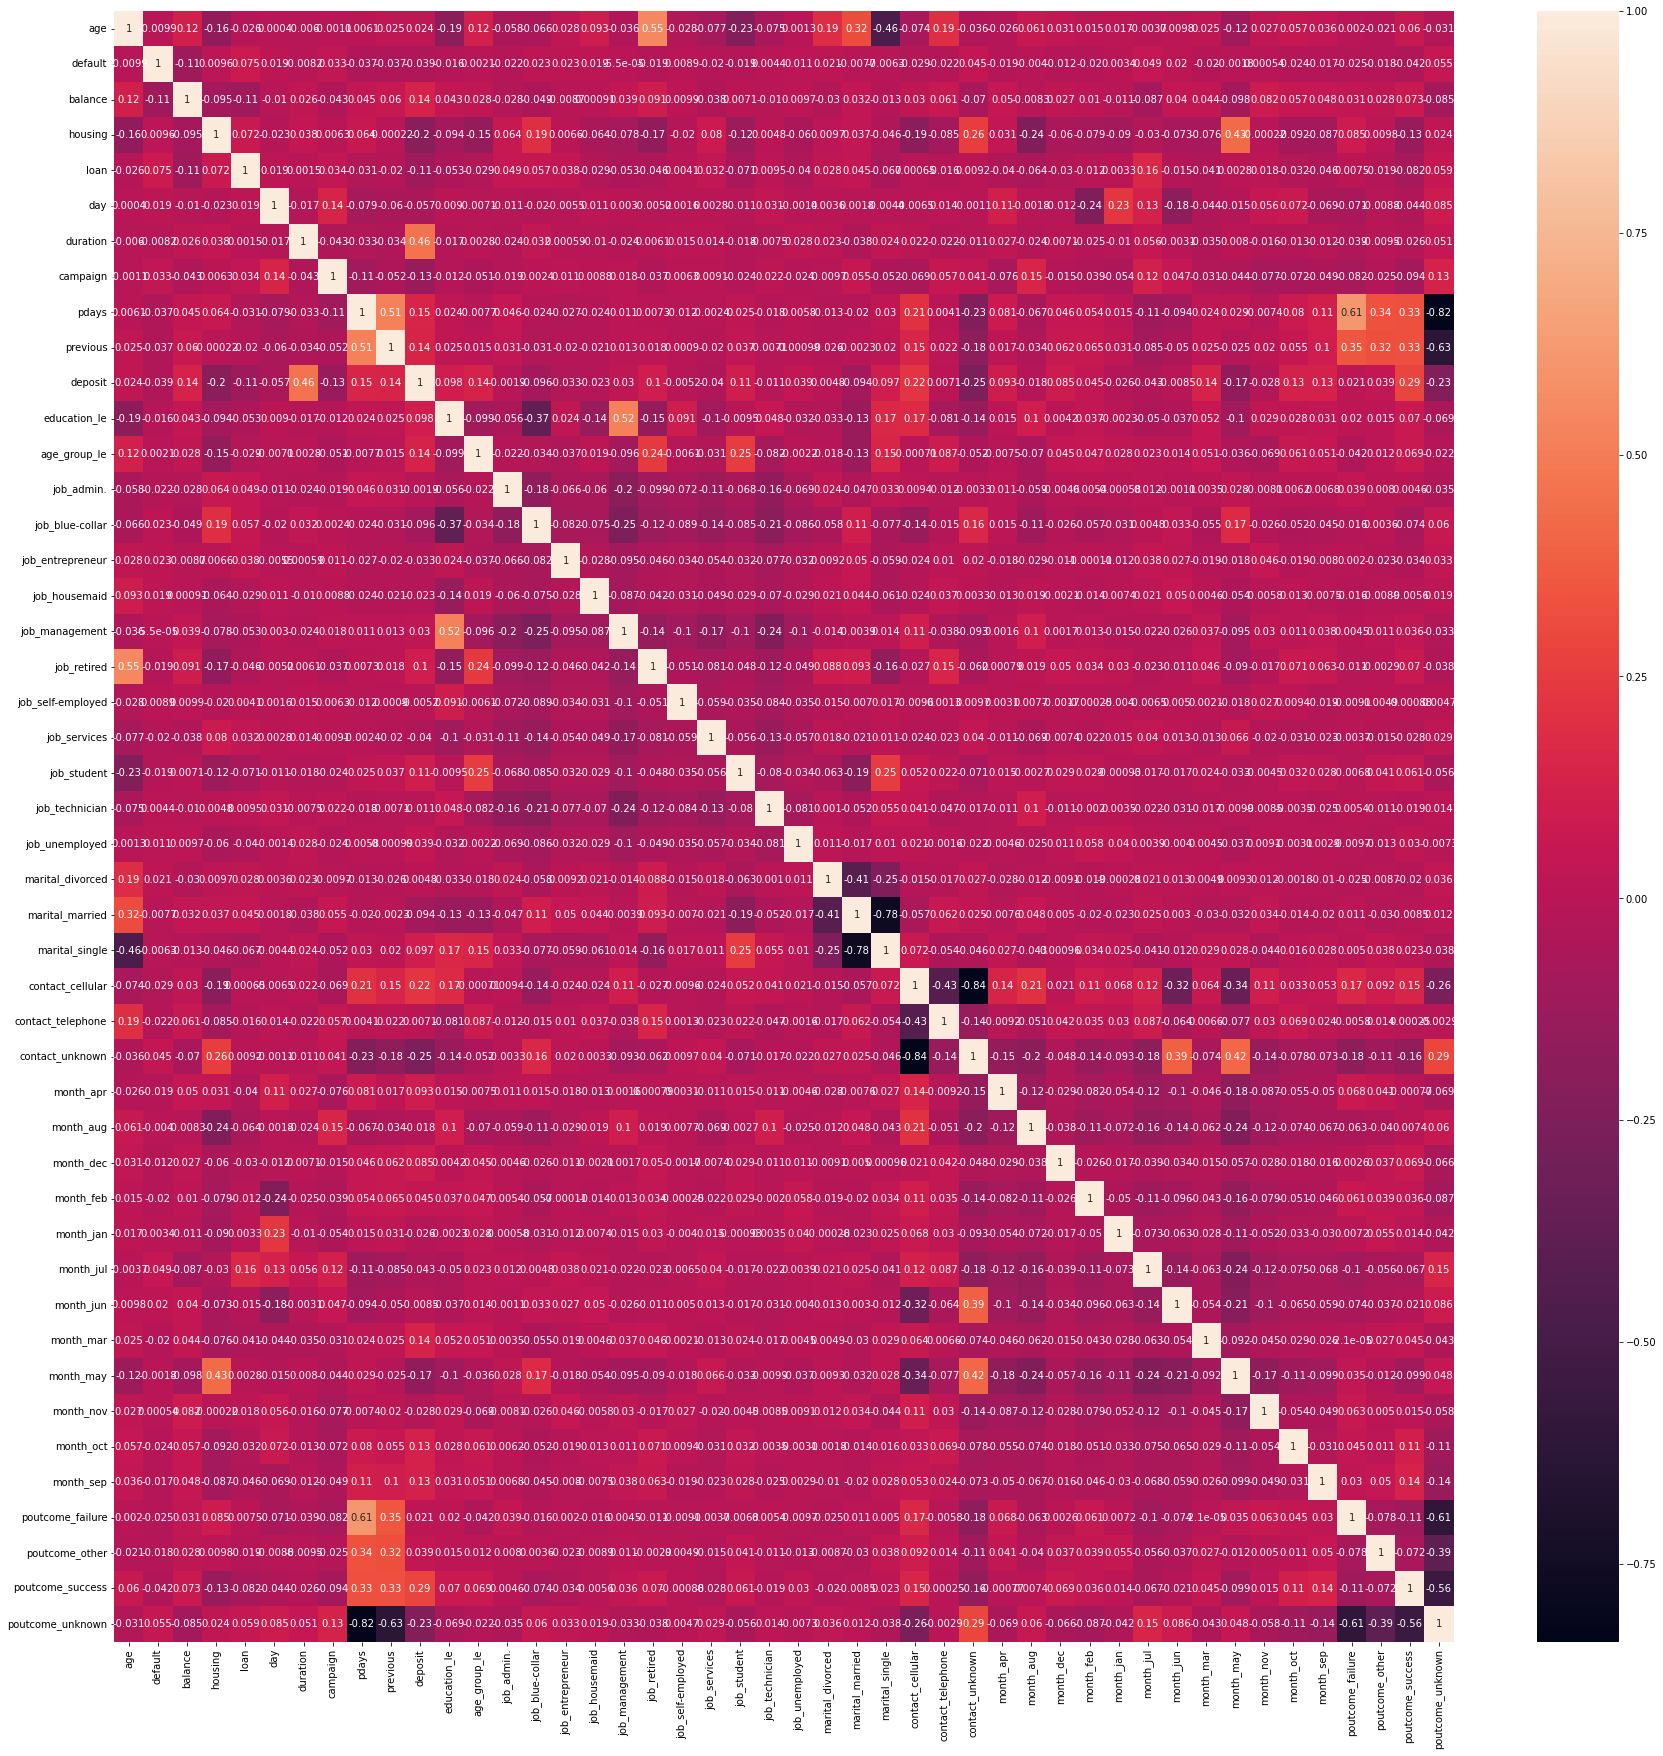

In [28]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
display(dfc_dumm.corr())
fig = plt.figure(figsize=(30, 30))
sns.heatmap(dfc_dumm.corr(),annot=True)


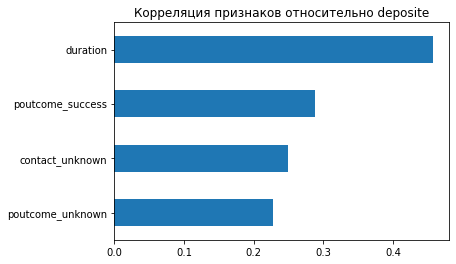

In [29]:
corr=dfc_dumm.corr()
corr['deposit'].apply(lambda x: abs (x)).sort_values()[-5:-1].plot.barh()
plt.title('Корреляция признаков относительно deposite')
plt.show()

### Задание 5

In [30]:
X = dfc_dumm.drop(['deposit'], axis=1)
y = dfc_dumm['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [31]:
# рассчитайте необходимые показатели
print(X_test.shape[0])
print(y_test.mean())

3335
0.46326836581709147


### Задание 6

In [32]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(k=15)
X_best_train = selector.fit_transform(X_train,y_train)
col_names = [column[0] for column in zip(X_train.columns, selector.get_support()) if column[1]] # Получаем список признаков
X_best_train = pd.DataFrame(data=X_best_train, columns=col_names)# переводим в Dataframe для удобства восприятия
print(X_best_train.columns)
X_best_test = X_test[col_names]

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_le', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [33]:
selector = SelectKBest(k=15)
X_best_train = selector.fit_transform(X_train,y_train)
col_names = [column[0] for column in zip(X_train.columns, selector.get_support()) if column[1]] # Получаем список признаков
X_best_train = pd.DataFrame(data=X_best_train, columns=col_names)# переводим в Dataframe для удобства восприятия
print(X_best_train.columns)
X_best_test = X_test[col_names]

Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group_le', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


### Задание 7

In [34]:
# нормализуйте данные с помощью minmaxsxaler
scaler=preprocessing.MinMaxScaler()
scaler.fit(X_best_train) 
X_train_scaled=scaler.transform(X_best_train)
X_test_scaled =scaler.transform (X_best_test)
X_train_scaled== pd.DataFrame(data=X_train_scaled) #переведем в DataFrame для удобства представления
X_test_scaled = pd.DataFrame(data=X_test_scaled)
round(X_test_scaled[X_test_scaled.columns[0]].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [35]:
# обучите логистическую регрессию и рассчитайте метрики качества
regress_model=linear_model.LogisticRegression(solver='sag',random_state=42, max_iter=1000)
regress_model.fit(X_train_scaled,y_train)
y_predict_reg = regress_model.predict(X_test_scaled)
display(metrics.accuracy_score(y_test,y_predict_reg))

0.8047976011994002

In [36]:
print(metrics.classification_report(y_test,y_predict_reg))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 2

In [37]:
# обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=7,min_samples_leaf=10)
tree_model.fit(X_train_scaled,y_train)
y_predict_tree=tree_model.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_predict_tree))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [38]:
print(metrics.f1_score(y_test,y_predict_tree))

0.8064823641563393


### Задание 3

In [39]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
parametrs = {'min_samples_split':[2,5,7,10],'max_depth':[3,5,7]}
model_cv=GridSearchCV(tree.DecisionTreeClassifier(), parametrs,cv=3, scoring=('accuracy'),return_train_score=True)
model_cv.fit(X_train_scaled, y_train)
y_predict_tree_cv=model_cv.predict(X_test_scaled)
print(metrics.classification_report(y_test,y_predict_tree_cv))
print(model_cv.best_params_)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335

{'max_depth': 7, 'min_samples_split': 10}


In [40]:
print(metrics.f1_score(y_test,y_predict_tree_cv))

0.8026905829596412


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [41]:
# обучите на ваших данных случайный лес
random_forest = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini', 
    max_depth=10, 
    min_samples_leaf=5,
    random_state=42
)

random_forest.fit(X_train_scaled, y_train)

y_pred_rf = random_forest.predict(X_test_scaled)


print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [42]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    loss='deviance', 
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
gb.fit(X_train_scaled, y_train)

y_pred_gb  = gb.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание3

In [43]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
estimators = [
    ('gb', GradientBoostingClassifier(loss='deviance', learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42)),
    ('rm', linear_model.LogisticRegression(solver='sag',random_state=42, max_iter=1000)),
    ('tm', tree.DecisionTreeClassifier(criterion='entropy',random_state=42,max_depth=7,min_samples_leaf=10)),
    ('rf',ensemble.RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=10,min_samples_leaf=5,random_state=42))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(n_estimators=10,
                                          random_state=42)
)
reg.fit(X_train_scaled, y_train)

y_pred_reg = reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_pred_reg))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1790
           1       0.78      0.78      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 4

In [44]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE

estimator = GradientBoostingClassifier(
    loss='deviance', 
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
selector_gb = RFE(estimator, n_features_to_select=3, step=1)
#selector_gb = selector.fit(X_train_scaled, y_train)

In [45]:
X_best_train_scal = selector_gb.fit_transform(X_train_scaled,y_train)
col_names = [column[0] for column in zip(X_train.columns, selector_gb.get_support()) if column[1]] # Получаем список признаков
X_best_train_scal = pd.DataFrame(data=X_best_train_scal, columns=col_names)# переводим в Dataframe для удобства восприятия
print(X_best_train_scal.columns)

Index(['age', 'balance', 'job_blue-collar'], dtype='object')


Признак: 0, Score: 0.060
Признак: 1, Score: 0.047
Признак: 2, Score: 0.502
Признак: 3, Score: 0.017
Признак: 4, Score: 0.056
Признак: 5, Score: 0.009
Признак: 6, Score: 0.042
Признак: 7, Score: 0.005
Признак: 8, Score: 0.074
Признак: 9, Score: 0.026
Признак: 10, Score: 0.015
Признак: 11, Score: 0.019
Признак: 12, Score: 0.013
Признак: 13, Score: 0.116
Признак: 14, Score: 0.000


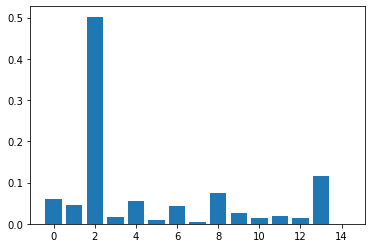

In [46]:
import matplotlib.pyplot  as plt
importance = gb.feature_importances_
for i,score in enumerate(importance):
  print('Признак: %0d, Score: %.3f' % (i,score))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

### Задание 5

In [47]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.3f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2022-08-25 15:13:43,610] A new study created in memory with name: RandomForestClassifier
[I 2022-08-25 15:13:44,656] Trial 0 finished with value: 0.846286701208981 and parameters: {'n_estimators': 117, 'max_depth': 14, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.846286701208981.
[I 2022-08-25 15:13:45,783] Trial 1 finished with value: 0.8483040201005025 and parameters: {'n_estimators': 131, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8483040201005025.
[I 2022-08-25 15:13:47,124] Trial 2 finished with value: 0.8783910196445276 and parameters: {'n_estimators': 134, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8783910196445276.
[I 2022-08-25 15:13:48,869] Trial 3 finished with value: 0.8686268376603066 and parameters: {'n_estimators': 183, 'max_depth': 26, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8783910196445276.
[I 2022-08-25 15:13:49,761] Trial 4 finished with value: 0.841724354940214 and parameters: {'n_est

accuracy на тестовом наборе: 0.827
f1_score на тестовом наборе: 0.817


In [48]:
#Общий вывод f1_score моделей для сравнения
print('f1_score на тестовом наборе логистическая регрессия: {:.3f}'.format(metrics.f1_score(y_test, y_predict_reg)))
print('f1_score на тестовом наборе решающие деревья: {:.3f}'.format(metrics.f1_score(y_test, y_predict_tree)))
print('f1_score на тестовом наборе GridSearchCV: {:.3f}'.format(metrics.f1_score(y_test, y_predict_tree_cv)))
print('f1_score на тестовом наборе случайный лес: {:.3f}'.format(metrics.f1_score(y_test, y_pred_rf)))
print('f1_score на тестовом наборе градиентный бустинг: {:.3f}'.format(metrics.f1_score(y_test, y_pred_gb)))
print('f1_score на тестовом наборе Стекинг: {:.3f}'.format(metrics.f1_score(y_test, y_pred_reg)))
print('f1_score на тестовом наборе Optuna: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе логистическая регрессия: 0.777
f1_score на тестовом наборе решающие деревья: 0.806
f1_score на тестовом наборе GridSearchCV: 0.803
f1_score на тестовом наборе случайный лес: 0.819
f1_score на тестовом наборе градиентный бустинг: 0.817
f1_score на тестовом наборе Стекинг: 0.781
f1_score на тестовом наборе Optuna: 0.817
